
# Stack Overflow Developer Survey 2025 - AI Adoption, Models, and Agents

This notebook follows the **CRISP-DM** process: business understanding, data understanding, data preparation, modeling, evaluatio. It analyzes the uploaded `survey_results_public2025.csv` file. The model built is for illustrative purposes. It uses only a handful of categorical features and is **not** optimized.


In [1]:
#Import required python Libraries
import pandas as pd, numpy as np, os, re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

plt.rcParams['figure.dpi']=120
csv_path = "/survey_results_public2025.csv" 

# csv_path = '/survey_results_public2025.csv'
df_input = pd.read_csv(csv_path)
print(df_input.shape)
df_input.head(2)


C:\Users\smatam\AppData\Local\Temp\ipykernel_20260\1938128978.py:16: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df_input = pd.read_csv(csv_path)


(49191, 172)


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0


In [3]:
# Select required columns for the analysis
cols = [
    "ResponseId","AIThreat","AIAgents","AISelect","AIModelsHaveWorkedWith","AISent",
    "Age","DevType","OrgSize","RemoteWork","Country"
]

# Create a new dataframe with only these columns
df_subset = df_input[cols].copy()

df_subset.head()

,ResponseId,AIThreat,AIAgents,AISelect,AIModelsHaveWorkedWith,AISent,Age,DevType,OrgSize,RemoteWork,Country
0,1,I'm not sure,"Yes, I use AI agents at work monthly or infreq...","Yes, I use AI tools monthly or infrequently",openAI GPT (chatbot models);openAI Image gener...,Indifferent,25-34 years old,"Developer, mobile",20 to 99 employees,Remote,Ukraine
1,2,I'm not sure,"No, and I don't plan to","Yes, I use AI tools weekly",openAI GPT (chatbot models),Indifferent,25-34 years old,"Developer, back-end",500 to 999 employees,"Hybrid (some in-person, leans heavy to flexibi...",Netherlands
2,3,No,"Yes, I use AI agents at work weekly","Yes, I use AI tools daily",Gemini (Flash general purpose models);openAI G...,Favorable,35-44 years old,"Developer, front-end",NaN,NaN,Ukraine
3,4,No,"Yes, I use AI agents at work monthly or infreq...","Yes, I use AI tools weekly",NaN,Favorable,35-44 years old,"Developer, back-end","10,000 or more employees",Remote,Ukraine
4,5,No,"No, and I don't plan to","Yes, I use AI tools weekly",openAI GPT (chatbot models),Favorable,35-44 years old,Engineering manager,NaN,NaN,Ukraine


## Missing Values Overview

In [4]:
# Columns that must be non-null
required_cols = [
    "ResponseId","AIThreat","AIAgents","AISelect","AIModelsHaveWorkedWith","AISent"
]

# Work on a copy of only the required columns for missingness checks
req = df_input[required_cols].copy()

# Treat only blank or whitespace-only strings as missing (keep literal "NA" as valid)
req = req.apply(lambda s: s.replace(r'^\s*$', np.nan, regex=True))

# Build a mask of rows that have NO missing values in the required columns
mask_complete = ~req.isna().any(axis=1)

# Apply mask to the full dataframe (retaining all columns), 
# but dropping rows that fail the required fields
df_clean = df_input.loc[mask_complete].reset_index(drop=True)

print("Original shape:", df_input.shape)
print("After dropping rows with nulls in required columns:", df_clean.shape)

Original shape: (49191, 172)
After dropping rows with nulls in required columns: (15699, 172)


In [5]:
df_clean

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
3,5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...",60000.0,7.0
4,8,I am a developer by profession,35-44 years old,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",Employed,Engaged in paid work (20-29 hours per week);Tr...,22.0,"Yes, I am not new to coding but am learning ne...",Books / Physical media;Technical documentation...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I want to learn best practices;When I wan...,"Innovation, system design",72000.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15694,49144,I am a developer by profession,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Not employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools req...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,Advocating for oneself and community building....,NaN,2.0
15695,49145,I am a developer by profession,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,"Caring for dependents (children, elderly, etc.)",12.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Microsoft C...,NaN,When I don’t trust AI’s answers;When I want to...,NaN,NaN,7.0
15696,49176,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,NaN,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",...,NaN,llama.cpp,Grafana + Prometheus,NaN,ChatGPT;Claude Code;Google Gemini,Cursor,When I don’t trust AI’s answers;When I want to...,Software Architecture,NaN,8.0
15697,49178,I am learning to code,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Not employed,Engaged in paid work (less than 10 hours pe

***Why We Drop Nulls Only in Key AI‑Related Columns?***
For this analysis, we focus on understanding developers’ behaviors, perceptions, and usage patterns related to AI tools. To ensure clean, reliable insights, we restrict row‑dropping to only the columns essential to the analysis, rather than removing rows with missing data elsewhere.

***Why did we not Impute Missing Values?*** In This Survey
Because this dataset comes from human survey responses, imputing missing values would introduce artificial information that respondents never actually provided. In survey-based research, especially around perceptions, opinions, and behavior, it is common practice to avoid imputation unless absolutely necessary.

In [6]:
#Assing the cleaned df to new df for further analysis
df = df_clean


## Data Understanding & Cleaning
- We focus on AI-related columns: `AISelect` (usage frequency), `AIModelsHaveWorkedWith`, `AIThreat`, `AIAgents`, `AISent` (sentiment).
- We standardize multi-select columns and bucket free-text choices into consistent categories.


In [7]:
import pandas as pd
import numpy as np

sep = ';'

def split_multiselect(series: pd.Series) -> pd.Series:
    """
    Split semicolon-delimited strings in a Pandas Series into lists.

    This function:
      1) Drops missing (NaN) values,
      2) Converts remaining values to strings,
      3) Splits each string into a list of substrings using the global separator `sep` (default ';').

    Note:
        - The function returns only non-null rows because it calls ``Series.dropna()``.
        - The global variable ``sep`` controls the split delimiter.

    Parameters
    ----------
    series : pd.Series
        A Pandas Series containing delimited string values (and possibly NaNs).

    Returns
    -------
    pd.Series
        A Series containing lists of substrings for non-null entries.

    """
    return series.dropna().astype(str).str.split(sep)


def map_ai_usage(v):
    """
    Normalize raw AI tool usage frequency responses into a small set of categories.

    Mapping rules (case-insensitive):
        - Contains 'daily'               -> 'Daily'
        - Contains 'weekly'              -> 'Weekly'
        - Contains 'monthly', 'infrequent', or 'less than once'
                                         -> 'Monthly or less'
        - Contains \"don't plan\" or \"don't use\"
                                         -> 'Do not use'
        - NaN                            -> np.nan
        - Otherwise                      -> 'Other'

    Parameters
    ----------
    v : Any
        A single value (e.g., from a DataFrame column) representing usage frequency.
        Can be string-like or NaN.

    Returns
    -------
    str | float
        One of {'Daily', 'Weekly', 'Monthly or less', 'Do not use', 'Other'} or np.nan if input is missing.

    """
    if pd.isna(v):
        return np.nan
    s = str(v).lower()
    if 'daily' in s:
        return 'Daily'
    if 'weekly' in s:
        return 'Weekly'
    if 'monthly' in s or 'infrequent' in s or 'less than once' in s:
        return 'Monthly or less'
    if "don't plan" in s or "don't use" in s:
        return 'Do not use'
    return 'Other'

ai_usage = df['AISelect'].map(map_ai_usage)
ai_usage.value_counts(dropna=True)

Daily              10351
Weekly              3260
Monthly or less     1551
Do not use           303
Other                234
Name: AISelect, dtype: int64


## Exploratory Analysis (EDA)
### 1) How often do developers use AI tools?


Daily              10351
Weekly              3260
Monthly or less     1551
Do not use           303
Other                234
Name: AISelect, dtype: int64

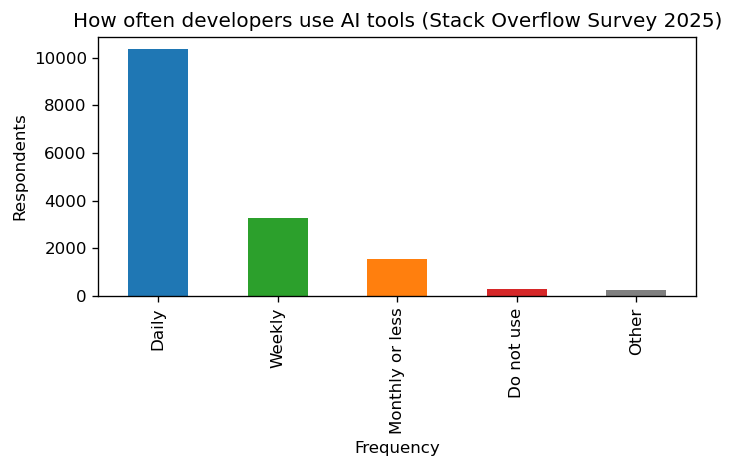

In [8]:
ai_usage_dist = ai_usage.value_counts().reindex(['Daily','Weekly','Monthly or less','Do not use','Other']).dropna()
ax = ai_usage_dist.plot(kind='bar', color=['#1f77b4','#2ca02c','#ff7f0e','#d62728','#7f7f7f'])
ax.set_title('How often developers use AI tools (Stack Overflow Survey 2025)')
ax.set_ylabel('Respondents')
ax.set_xlabel('Frequency')
plt.tight_layout();
plt.savefig('figs/ai_usage_distribution.png', dpi=200)
ai_usage_dist


Most developers use AI tools regularly. Nearly half use them daily, making it the dominant behavior, as shown by the tallest bar in the chart. Another use AI weekly or monthly, onle 234 do not use AI, a much smaller bar compared to daily usage.
Overall, the visualization shows that AI has become a routine, integrated part of everyday development work, not just an occasional resource.


### 2) What AI models/tools are most used?


In [9]:
models_used = split_multiselect(df['AIModelsHaveWorkedWith'])
from collections import Counter
model_counts = Counter([m.strip() for lst in models_used for m in lst if isinstance(m,str) and m.strip()])
import pandas as pd

pd.Series(model_counts).sort_values(ascending=False).head(12)


openAI GPT (chatbot models)              12974
Anthropic: Claude Sonnet                  6878
Gemini (Flash general purpose models)     5631
openAI Reasoning models                   5551
openAI Image generating models            4253
Gemini (Pro Reasoning models)             4093
DeepSeek (R- Reasoning models)            3704
Meta Llama (all models)                   2853
DeepSeek (V- General purpose models)      2272
X Grok models                             1761
Mistral AI models                         1659
Perplexity Sonar models                   1198
dtype: int64

openAI GPT (chatbot models)              12974
Anthropic: Claude Sonnet                  6878
Gemini (Flash general purpose models)     5631
openAI Reasoning models                   5551
openAI Image generating models            4253
Gemini (Pro Reasoning models)             4093
DeepSeek (R- Reasoning models)            3704
Meta Llama (all models)                   2853
DeepSeek (V- General purpose models)      2272
X Grok models                             1761
Mistral AI models                         1659
Perplexity Sonar models                   1198
dtype: int64

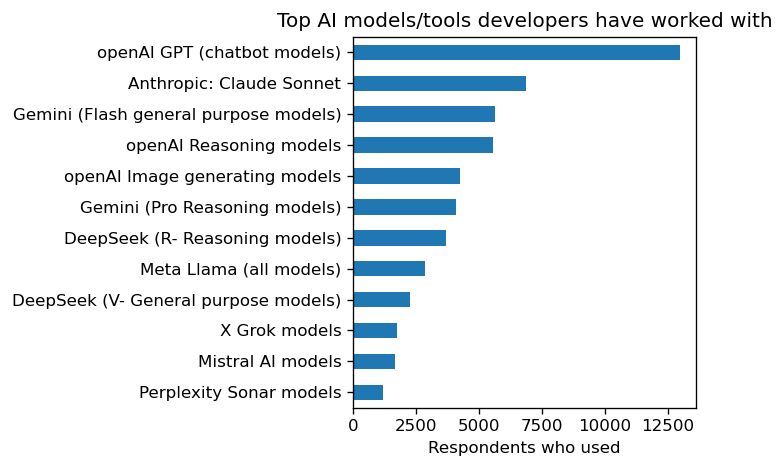

In [10]:
# Plot top 12
import pandas as pd
_top = pd.Series(model_counts).sort_values(ascending=False).head(12)
ax = _top.sort_values().plot(kind='barh', color='#1f77b4')
ax.set_title('Top AI models/tools developers have worked with')
ax.set_xlabel('Respondents who used')
plt.tight_layout();
plt.savefig('figs/top_ai_models_used.png', dpi=200)
_top


The chart shows that OpenAI GPT chatbot models are by far the most widely used, with 12,974 developers, clearly standing out as the longest bar. The next tier of tools, Claude Sonnet (6,878), Gemini Flash (5,631), and OpenAI Reasoning models (5,551) form a strong middle group, but each is roughly half or less of GPT’s usage.
The shortest bars belong to X Grok and Perplexity Sonar, indicating niche adoption.
Overall, the visualization makes the pattern clear :
OpenAI dominates developer usage, followed by a competitive cluster (Claude, Gemini, DeepSeek), while all others have significantly smaller but growing user bases.


### 3) Do developers see AI as a threat to their job?


No        9823
Unsure    3443
Yes       2433
Name: AIThreat, dtype: int64

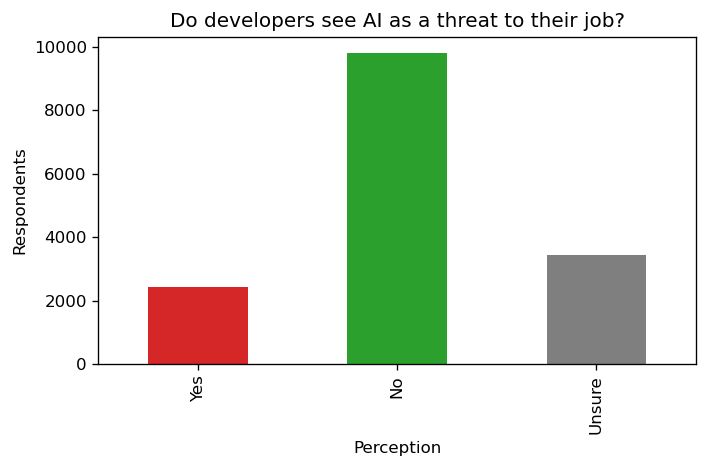

In [11]:
def norm_threat(v):
    """
    Normalize free-text survey responses

    This helper converts varied user-entered values (e.g., "yeah", "not sure",
    "partly", "no it isnt") into one of five standardized labels:

        - "Yes"
        - "No"
        - "Unsure"
        - "Somewhat"
        - "Other"

    The normalization is case-insensitive, trims surrounding whitespace, and
    handles missing values.

    Parameters
    ------------
    v : Any
        A single value representing a respondent's answer. Can be a string,
        a number, or missing (e.g., `numpy.nan`). Non-string values are
        converted to string before normalization.

    Returns
    -------
    str or float
        One of:
           "Yes"      : if the response is in {'yes','yeah','y','yes it is',
                           'yes, definitely','yes, somewhat','yes to a great extent',
                           'yes its a threat','partly'}
            "No"       : if the response is in {'no','no it isnt','no, not really',
                           'no it is not','not at all'}
            "Unsure"   : if the response contains 'not sure', "i'm not sure",
                           or 'unsure' (substring match)
            "Somewhat" : if the response contains 'somewhat' or 'part' (substring match)
            "Other"    : for all remaining non-missing values
             numpy.nan  : if the input is missing (i.e., `pandas.isna(v)` is True)

    Notes
    -------
    - Matching is performed in the following order:
        1) Exact matches for "Yes" list
        2) Exact matches for "No" list
        3) Substring checks for "Unsure"
        4) Substring checks for "Somewhat"
        5) Fallback to "Other"
      This means a response like "somewhat unsure" will be classified as "Unsure"
      due to the earlier check, while a response containing only "somewhat" or "part"
      is classified as "Somewhat".

    - The function lowercases the input and strips leading/trailing whitespace
      before evaluating.
    """
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    if s in ['yes','yeah','y','yes it is','yes, definitely','yes, somewhat','yes to a great extent','yes its a threat','partly']:
        return 'Yes'
    if s in ['no','no it isnt','no, not really','no it is not','not at all']:
        return 'No'
    if 'not sure' in s or "i'm not sure" in s or 'unsure' in s:
        return 'Unsure'
    if 'somewhat' in s or 'part' in s:
        return 'Somewhat'
    return 'Other'

threat = df['AIThreat'].map(norm_threat)
threat_dist = threat.value_counts()
ax = threat_dist.reindex(['Yes','No','Unsure','Somewhat','Other']).dropna().plot(kind='bar', color=['#d62728','#2ca02c','#7f7f7f','#ff7f0e','#1f77b4'])
ax.set_title('Do developers see AI as a threat to their job?')
ax.set_ylabel('Respondents')
ax.set_xlabel('Perception')
plt.tight_layout();
plt.savefig('figs/ai_threat_perception.png', dpi=200)
threat_dist

The chart shows that most developers do not see AI as a threat to their job. The “No” bar is by far the tallest, with 9823 respondents, indicating strong confidence that AI will not replace their roles. A smaller but notable group -3443 developers are unsure, reflected by the mid‑sized grey bar. The “Yes” group is the smallest (2433), showing that only a minority view AI as a direct job threat.
Overall, the visualization makes it clear that developer sentiment leans strongly toward AI being helpful rather than harmful, with uncertainty outweighing fear, and fear being the least common stance.


### 4) AI agent adoption at work


In [12]:
def map_agent(v):
    """
    Normalize free-text responses about AI agent usage frequency into
    standardized usage buckets.

    This function interprets a variety of survey responses (e.g., "daily",
    "less than once a month", "no, but I plan to") and maps them into a
    consistent set of categories:

        - "Daily"
        - "Weekly"
        - "Monthly or less"
        - "Plan to start"
        - "Do not plan"
        - "Other"

    The mapping is case-insensitive, tolerant of varied phrasing, and handles
    missing values.

    Parameters
    ----------
    v : Any
        A single survey response. Can be a string, number, or missing value.
        Non-string values are converted to strings before processing. Missing
        values (as detected by `pandas.isna`) return `numpy.nan`.

    Returns
    -------
    str or float
        One of the following:
           "Daily"            : if the response contains 'daily'
           "Weekly"           : if the response contains 'weekly'
           "Monthly or less"  : if the response contains 'monthly',
                                 'infrequent', or 'less than once'
           "Plan to start"    : if the response contains 'no, but i plan'
           "Do not plan"      : if the response contains "no, and i don't plan"
           "Other"            : all other non-missing responses
           numpy.nan          : if input is missing

    Notes
    -----
    - The function lowercases the response before evaluating.
    - The matching is done in a top‑down order; earlier conditions take priority.
    - Substring matching (e.g., 'less than once') allows capturing a variety of
      respondent wording patterns in real survey data.

    """
    if pd.isna(v): return np.nan
    s = str(v).lower()
    if 'daily' in s: return 'Daily'
    if 'weekly' in s: return 'Weekly'
    if 'monthly' in s or 'infrequent' in s or 'less than once' in s: return 'Monthly or less'
    if 'no, but i plan' in s: return 'Plan to start'
    if "no, and i don't plan" in s: return 'Do not plan'
    return 'Other'
agent_bucket = df['AIAgents'].map(map_agent)
agent_bucket.value_counts().reindex(['Daily','Weekly','Monthly or less','Plan to start','Do not plan','Other']).dropna()

Daily              3111
Weekly             1926
Monthly or less    1424
Plan to start      3067
Do not plan        3577
Other              2594
Name: AIAgents, dtype: int64

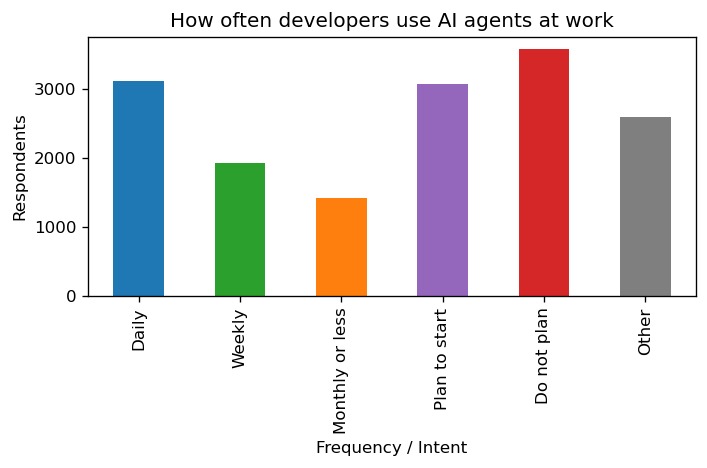

In [13]:
ax = agent_bucket.value_counts().reindex(['Daily','Weekly','Monthly or less','Plan to start','Do not plan','Other']).dropna().plot(kind='bar', color=['#1f77b4','#2ca02c','#ff7f0e','#9467bd','#d62728','#7f7f7f'])
ax.set_title('How often developers use AI agents at work')
ax.set_ylabel('Respondents')
ax.set_xlabel('Frequency / Intent')
plt.tight_layout();
plt.savefig('figs/ai_agent_adoption.png', dpi=200)


Above chart indicates actual usage is much lower,These shorter bars highlight that regular, hands‑on adoption is still limited. The "Other" category (2594) sits between active use and planning, suggesting mixed or experimental engagement.
Overall, the visualization indicates that AI agents are still early in their workplace adoption curve, with far more developers planning or not planning than actively using them today. 


### 5) Overall sentiment toward AI tools


Favorable           6959
Very favorable      4996
Indifferent         2193
Unfavorable          995
Very unfavorable     398
Unsure               158
Name: AISent, dtype: int64

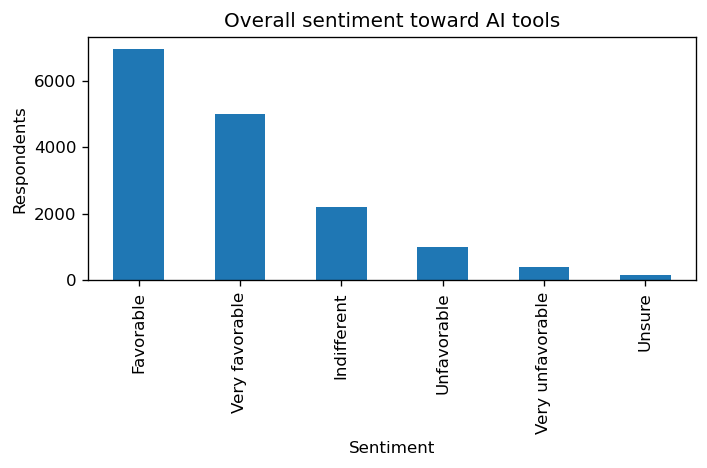

In [14]:
sent = df['AISent'].dropna().value_counts()
ax = sent.plot(kind='bar', color='#1f77b4')
ax.set_title('Overall sentiment toward AI tools')
ax.set_ylabel('Respondents')
ax.set_xlabel('Sentiment')
plt.tight_layout();
plt.savefig('figs/ai_sentiment.png', dpi=200)
sent


Overall, the visualization shows that developers overwhelmingly lean positive rather than negative, with unfavorable sentiment being a clear minority


## Modeling: Predicting Daily/Weekly AI Tool Usage
We build a logistic regression model to predict whether a respondent is a **daily/weekly** AI user from non-technical demographics: `Age`, `DevType`, `OrgSize`, `RemoteWork`, and `Country`.


In [15]:
label = ai_usage.isin(['Daily','Weekly']).astype(float).replace({np.nan: np.nan})
X = df[['Age','DevType','OrgSize','RemoteWork','Country']].copy()
mask = label.notna() & X.notna().all(axis=1)
X2, y2 = X[mask], label[mask].astype(int)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=50), list(X2.columns))
])

clf = Pipeline([
    ('pre', pre),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

Xtr, Xte, ytr, yte = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)
yp_proba = clf.predict_proba(Xte)[:,1]
acc = accuracy_score(yte, yp)
prec, rec, f1, _ = precision_recall_fscore_support(yte, yp, average='binary', zero_division=0)
auc = roc_auc_score(yte, yp_proba)
acc, prec, rec, f1, auc


(0.5759096612296111,
 0.8931718061674009,
 0.5834532374100719,
 0.7058311575282855,
 0.5704445267315559)

**Interpretation**: The model is better than chance but not strong. An AUC around 0.57 indicates limited separability using demographics alone. Precision is decent, but recall is only moderate, so it will miss a fair number of true Daily/Weekly users


## Scenario (Deployment):
**Example**: A back-end developer, age 25 - 34, in a 100-499 employee company, hybrid work, based in the United States.

We estimate the probability that this persona is a **daily/weekly AI user**.


In [16]:
scenario = pd.DataFrame({
    'Age':['25-34 years old'],
    'DevType':['Developer, back-end'],
    'OrgSize':['100 to 499 employees'],
    'RemoteWork':['Hybrid (some in-person, leans heavy to flexibility)'],
    'Country':['United States of America']
})
clf.predict_proba(scenario)[:,1][0]


0.38429326657669494

According to the model, this persona has a 39% chance of being a daily/weekly AI user.
Since 39% is below 0.5, the model would classify this persona as not a daily/weekly user.
This probability is also lower than the overall population rate of daily+weekly usage, meaning the model sees this persona as less likely than average to use AI frequently.The model uses only non‑technical demographic features:

Age,
Developer type,
Organization size,
Remote work setup,
Country

These give some signal, but not enough to make a highly confident prediction.
This example is predicted to be a moderate‑likelihood AI user, but not highly likely, based on demographics alone.